In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_roi_t1t2_normalized_k5_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 276)
(734160, 1)
validation
(101248, 276)
(101248, 1)
test
(100432, 276)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 276)]             0         


 dense (Dense)               (None, 1024)              283648    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 972801 (3.71 MB)


Trainable params: 972801 (3.71 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:17 - loss: 0.2903 - STD: 8.5154e-05 - MAE: 0.5301

 6/74 [=>............................] - ETA: 0s - loss: 0.0758 - STD: 1.3175e-04 - MAE: 0.2048  

 8/74 [==>...........................] - ETA: 5s - loss: 0.0661 - STD: 1.0537e-04 - MAE: 0.1859

13/74 [====>.........................] - ETA: 3s - loss: 0.0516 - STD: 6.8055e-05 - MAE: 0.1701

18/74 [======>.......................] - ETA: 2s - loss: 0.0454 - STD: 4.9883e-05 - MAE: 0.1630

23/74 [========>.....................] - ETA: 1s - loss: 0.0408 - STD: 4.0022e-05 - MAE: 0.1553

28/74 [==========>...................] - ETA: 1s - loss: 0.0364 - STD: 3.4472e-05 - MAE: 0.1447

34/74 [============>.................] - ETA: 1s - loss: 0.0317 - STD: 3.1069e-05 - MAE: 0.1329

39/74 [==============>...............] - ETA: 0s - loss: 0.0291 - STD: 2.9273e-05 - MAE: 0.1275

44/74 [================>.............] - ETA: 0s - loss: 0.0269 - STD: 2.7289e-05 - MAE: 0.1225

49/74 [==================>...........] - ETA: 0s - loss: 0.0251 - STD: 2.5318e-05 - MAE: 0.1176

54/74 [====================>.........] - ETA: 0s - loss: 0.0236 - STD: 2.3559e-05 - MAE: 0.1136

59/74 [======================>.......] - ETA: 0s - loss: 0.0224 - STD: 2.2120e-05 - MAE: 0.1102

64/74 [========================>.....] - ETA: 0s - loss: 0.0214 - STD: 2.0901e-05 - MAE: 0.1076

69/74 [==========================>...] - ETA: 0s - loss: 0.0205 - STD: 1.9760e-05 - MAE: 0.1054

74/74 [==============================] - ETA: 0s - loss: 0.0197 - STD: 1.8856e-05 - MAE: 0.1034

74/74 [==============================] - 3s 25ms/step - loss: 0.0197 - STD: 1.8856e-05 - MAE: 0.1034 - val_loss: 0.0086 - val_STD: 5.1176e-06 - val_MAE: 0.0714


Epoch 2/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0090 - STD: 7.7913e-06 - MAE: 0.0745

 6/74 [=>............................] - ETA: 0s - loss: 0.0093 - STD: 6.6812e-06 - MAE: 0.0749

11/74 [===>..........................] - ETA: 0s - loss: 0.0093 - STD: 6.2630e-06 - MAE: 0.0751

16/74 [=====>........................] - ETA: 0s - loss: 0.0092 - STD: 6.3075e-06 - MAE: 0.0750

21/74 [=======>......................] - ETA: 0s - loss: 0.0092 - STD: 6.5855e-06 - MAE: 0.0752

26/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 6.6880e-06 - MAE: 0.0752

31/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 6.5973e-06 - MAE: 0.0751

37/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 6.5814e-06 - MAE: 0.0752

42/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 6.6397e-06 - MAE: 0.0752

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 6.6283e-06 - MAE: 0.0753

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 6.7001e-06 - MAE: 0.0753

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 6.7865e-06 - MAE: 0.0753

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 6.8476e-06 - MAE: 0.0753

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 6.8468e-06 - MAE: 0.0753

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 6.8501e-06 - MAE: 0.0754

74/74 [==============================] - 1s 11ms/step - loss: 0.0092 - STD: 6.8580e-06 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 5.3016e-06 - val_MAE: 0.0716


Epoch 3/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0095 - STD: 7.4770e-06 - MAE: 0.0764

 6/74 [=>............................] - ETA: 0s - loss: 0.0093 - STD: 7.5002e-06 - MAE: 0.0755

11/74 [===>..........................] - ETA: 0s - loss: 0.0093 - STD: 7.5503e-06 - MAE: 0.0755

16/74 [=====>........................] - ETA: 0s - loss: 0.0093 - STD: 7.4162e-06 - MAE: 0.0755

22/74 [=======>......................] - ETA: 0s - loss: 0.0093 - STD: 7.5568e-06 - MAE: 0.0756

27/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 7.5541e-06 - MAE: 0.0755

32/74 [===========>..................] - ETA: 0s - loss: 0.0093 - STD: 7.5663e-06 - MAE: 0.0755

37/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 7.6627e-06 - MAE: 0.0755

42/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 7.7552e-06 - MAE: 0.0755

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 7.7737e-06 - MAE: 0.0754

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 7.8624e-06 - MAE: 0.0754

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.9778e-06 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 8.1181e-06 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 8.1726e-06 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 8.2289e-06 - MAE: 0.0754

74/74 [==============================] - 1s 12ms/step - loss: 0.0092 - STD: 8.2289e-06 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 5.8405e-06 - val_MAE: 0.0715


Epoch 4/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0093 - STD: 8.3366e-06 - MAE: 0.0757

 6/74 [=>............................] - ETA: 0s - loss: 0.0092 - STD: 9.4376e-06 - MAE: 0.0753

11/74 [===>..........................] - ETA: 0s - loss: 0.0092 - STD: 9.4312e-06 - MAE: 0.0753

16/74 [=====>........................] - ETA: 0s - loss: 0.0092 - STD: 9.5766e-06 - MAE: 0.0753

21/74 [=======>......................] - ETA: 0s - loss: 0.0092 - STD: 9.8066e-06 - MAE: 0.0753

27/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 1.0104e-05 - MAE: 0.0753

33/74 [============>.................] - ETA: 0s - loss: 0.0092 - STD: 1.0412e-05 - MAE: 0.0754

38/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 1.0759e-05 - MAE: 0.0755

43/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 1.1012e-05 - MAE: 0.0754

48/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 1.1255e-05 - MAE: 0.0755

53/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 1.1576e-05 - MAE: 0.0754

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.1747e-05 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.1804e-05 - MAE: 0.0755

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.1952e-05 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.2115e-05 - MAE: 0.0754

74/74 [==============================] - 1s 12ms/step - loss: 0.0092 - STD: 1.2167e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.0184e-05 - val_MAE: 0.0715


Epoch 5/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0095 - STD: 1.4108e-05 - MAE: 0.0765

 6/74 [=>............................] - ETA: 0s - loss: 0.0093 - STD: 1.4785e-05 - MAE: 0.0758

11/74 [===>..........................] - ETA: 0s - loss: 0.0093 - STD: 1.5112e-05 - MAE: 0.0756

16/74 [=====>........................] - ETA: 0s - loss: 0.0093 - STD: 1.5372e-05 - MAE: 0.0756

21/74 [=======>......................] - ETA: 0s - loss: 0.0092 - STD: 1.5540e-05 - MAE: 0.0755

26/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 1.5720e-05 - MAE: 0.0754

32/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 1.6324e-05 - MAE: 0.0754

37/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 1.6726e-05 - MAE: 0.0754

42/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 1.7192e-05 - MAE: 0.0754

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 1.7622e-05 - MAE: 0.0754

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 1.8112e-05 - MAE: 0.0754

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.8586e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.8970e-05 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.9474e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.9925e-05 - MAE: 0.0754

74/74 [==============================] - 1s 12ms/step - loss: 0.0092 - STD: 2.0115e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 2.0057e-05 - val_MAE: 0.0714


Epoch 6/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0089 - STD: 2.7740e-05 - MAE: 0.0741

 6/74 [=>............................] - ETA: 0s - loss: 0.0092 - STD: 2.7345e-05 - MAE: 0.0751

11/74 [===>..........................] - ETA: 0s - loss: 0.0092 - STD: 2.7124e-05 - MAE: 0.0751

16/74 [=====>........................] - ETA: 0s - loss: 0.0092 - STD: 2.7567e-05 - MAE: 0.0752

21/74 [=======>......................] - ETA: 0s - loss: 0.0092 - STD: 2.7706e-05 - MAE: 0.0753

26/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 2.8584e-05 - MAE: 0.0753

32/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 2.9938e-05 - MAE: 0.0754

37/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 3.0958e-05 - MAE: 0.0754

42/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 3.1977e-05 - MAE: 0.0753

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 3.2987e-05 - MAE: 0.0753

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 3.3911e-05 - MAE: 0.0753

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 3.4872e-05 - MAE: 0.0753

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.5831e-05 - MAE: 0.0753

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.6859e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 3.7975e-05 - MAE: 0.0754

74/74 [==============================] - 1s 12ms/step - loss: 0.0092 - STD: 3.8445e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 4.1129e-05 - val_MAE: 0.0716


Epoch 7/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0093 - STD: 5.5156e-05 - MAE: 0.0753

 6/74 [=>............................] - ETA: 0s - loss: 0.0092 - STD: 5.7575e-05 - MAE: 0.0754

11/74 [===>..........................] - ETA: 0s - loss: 0.0092 - STD: 5.9267e-05 - MAE: 0.0755

16/74 [=====>........................] - ETA: 0s - loss: 0.0092 - STD: 6.0927e-05 - MAE: 0.0754

21/74 [=======>......................] - ETA: 0s - loss: 0.0092 - STD: 6.2714e-05 - MAE: 0.0753

26/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 6.4282e-05 - MAE: 0.0753

31/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 6.6148e-05 - MAE: 0.0753

36/74 [=============>................] - ETA: 0s - loss: 0.0092 - STD: 6.8210e-05 - MAE: 0.0754

41/74 [===============>..............] - ETA: 0s - loss: 0.0092 - STD: 7.0281e-05 - MAE: 0.0754

46/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 7.2340e-05 - MAE: 0.0754

51/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 7.4767e-05 - MAE: 0.0754

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.7795e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 8.0515e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 8.4168e-05 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 8.7471e-05 - MAE: 0.0754

74/74 [==============================] - 1s 12ms/step - loss: 0.0092 - STD: 8.8169e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.0640e-04 - val_MAE: 0.0716


Epoch 8/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0095 - STD: 1.3913e-04 - MAE: 0.0769

 6/74 [=>............................] - ETA: 0s - loss: 0.0093 - STD: 1.4664e-04 - MAE: 0.0758

11/74 [===>..........................] - ETA: 0s - loss: 0.0092 - STD: 1.5181e-04 - MAE: 0.0756

16/74 [=====>........................] - ETA: 0s - loss: 0.0092 - STD: 1.5852e-04 - MAE: 0.0755

21/74 [=======>......................] - ETA: 0s - loss: 0.0092 - STD: 1.6589e-04 - MAE: 0.0755

26/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 1.7272e-04 - MAE: 0.0754

31/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 1.8067e-04 - MAE: 0.0755

36/74 [=============>................] - ETA: 0s - loss: 0.0092 - STD: 1.8908e-04 - MAE: 0.0754

41/74 [===============>..............] - ETA: 0s - loss: 0.0092 - STD: 1.9794e-04 - MAE: 0.0754

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 2.1030e-04 - MAE: 0.0754

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 2.2163e-04 - MAE: 0.0753

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 2.3420e-04 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.4819e-04 - MAE: 0.0753

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.6358e-04 - MAE: 0.0753

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 2.8067e-04 - MAE: 0.0753

74/74 [==============================] - 1s 12ms/step - loss: 0.0092 - STD: 2.8814e-04 - MAE: 0.0753 - val_loss: 0.0086 - val_STD: 4.4333e-04 - val_MAE: 0.0715


Epoch 9/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0095 - STD: 5.8379e-04 - MAE: 0.0765

 6/74 [=>............................] - ETA: 0s - loss: 0.0092 - STD: 6.1637e-04 - MAE: 0.0755

12/74 [===>..........................] - ETA: 0s - loss: 0.0092 - STD: 6.6843e-04 - MAE: 0.0754

18/74 [======>.......................] - ETA: 0s - loss: 0.0092 - STD: 7.2851e-04 - MAE: 0.0753

24/74 [========>.....................] - ETA: 0s - loss: 0.0092 - STD: 7.9699e-04 - MAE: 0.0753

29/74 [==========>...................] - ETA: 0s - loss: 0.0092 - STD: 8.6312e-04 - MAE: 0.0753

35/74 [=============>................] - ETA: 0s - loss: 0.0092 - STD: 9.5740e-04 - MAE: 0.0752

40/74 [===============>..............] - ETA: 0s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751    

45/74 [=================>............] - ETA: 0s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0751

50/74 [===================>..........] - ETA: 0s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0750

55/74 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0749

61/74 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0749

66/74 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0018 - MAE: 0.0748

71/74 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0021 - MAE: 0.0747

74/74 [==============================] - 1s 11ms/step - loss: 0.0090 - STD: 0.0023 - MAE: 0.0747 - val_loss: 0.0079 - val_STD: 0.0054 - val_MAE: 0.0689


Epoch 10/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0087 - STD: 0.0068 - MAE: 0.0731

 6/74 [=>............................] - ETA: 0s - loss: 0.0085 - STD: 0.0078 - MAE: 0.0728

11/74 [===>..........................] - ETA: 0s - loss: 0.0084 - STD: 0.0087 - MAE: 0.0723

16/74 [=====>........................] - ETA: 0s - loss: 0.0083 - STD: 0.0098 - MAE: 0.0720

21/74 [=======>......................] - ETA: 0s - loss: 0.0083 - STD: 0.0111 - MAE: 0.0716

26/74 [=========>....................] - ETA: 0s - loss: 0.0081 - STD: 0.0127 - MAE: 0.0711

32/74 [===========>..................] - ETA: 0s - loss: 0.0080 - STD: 0.0148 - MAE: 0.0704

38/74 [==============>...............] - ETA: 0s - loss: 0.0078 - STD: 0.0174 - MAE: 0.0696

43/74 [================>.............] - ETA: 0s - loss: 0.0077 - STD: 0.0197 - MAE: 0.0690

49/74 [==================>...........] - ETA: 0s - loss: 0.0076 - STD: 0.0226 - MAE: 0.0683

54/74 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.0248 - MAE: 0.0678

59/74 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0268 - MAE: 0.0674

64/74 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0285 - MAE: 0.0670

69/74 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0300 - MAE: 0.0667

74/74 [==============================] - 1s 12ms/step - loss: 0.0072 - STD: 0.0313 - MAE: 0.0663 - val_loss: 0.0054 - val_STD: 0.0422 - val_MAE: 0.0565


Epoch 11/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0498 - MAE: 0.0616

 6/74 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0504 - MAE: 0.0622

11/74 [===>..........................] - ETA: 0s - loss: 0.0063 - STD: 0.0506 - MAE: 0.0617

17/74 [=====>........................] - ETA: 0s - loss: 0.0062 - STD: 0.0507 - MAE: 0.0616

23/74 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0509 - MAE: 0.0614

28/74 [==========>...................] - ETA: 0s - loss: 0.0062 - STD: 0.0511 - MAE: 0.0613

34/74 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0513 - MAE: 0.0612

40/74 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0516 - MAE: 0.0611

46/74 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0517 - MAE: 0.0610

52/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0519 - MAE: 0.0609

58/74 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0520 - MAE: 0.0608

64/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0522 - MAE: 0.0608

70/74 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0523 - MAE: 0.0608

74/74 [==============================] - 1s 11ms/step - loss: 0.0061 - STD: 0.0524 - MAE: 0.0608 - val_loss: 0.0054 - val_STD: 0.0469 - val_MAE: 0.0561


Epoch 12/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0606

 6/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0544 - MAE: 0.0602

11/74 [===>..........................] - ETA: 0s - loss: 0.0060 - STD: 0.0544 - MAE: 0.0600

16/74 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0544 - MAE: 0.0600

21/74 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0545 - MAE: 0.0600

27/74 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0545 - MAE: 0.0599

33/74 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0546 - MAE: 0.0598

38/74 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0546 - MAE: 0.0598

43/74 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0546 - MAE: 0.0598

48/74 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0548 - MAE: 0.0598

53/74 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0548 - MAE: 0.0598

58/74 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0548 - MAE: 0.0598

63/74 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0548 - MAE: 0.0597

68/74 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0550 - MAE: 0.0597

73/74 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0550 - MAE: 0.0597

74/74 [==============================] - 1s 12ms/step - loss: 0.0060 - STD: 0.0551 - MAE: 0.0597 - val_loss: 0.0054 - val_STD: 0.0458 - val_MAE: 0.0556


Epoch 13/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0567 - MAE: 0.0593

 6/74 [=>............................] - ETA: 0s - loss: 0.0059 - STD: 0.0564 - MAE: 0.0592

11/74 [===>..........................] - ETA: 0s - loss: 0.0058 - STD: 0.0566 - MAE: 0.0591

16/74 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0563 - MAE: 0.0591

22/74 [=======>......................] - ETA: 0s - loss: 0.0059 - STD: 0.0564 - MAE: 0.0592

28/74 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0563 - MAE: 0.0592

34/74 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0563 - MAE: 0.0592

39/74 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0563 - MAE: 0.0592

44/74 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0563 - MAE: 0.0592

50/74 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0563 - MAE: 0.0592

55/74 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0563 - MAE: 0.0592

60/74 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0564 - MAE: 0.0592

65/74 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0564 - MAE: 0.0592

70/74 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0564 - MAE: 0.0592

74/74 [==============================] - 1s 11ms/step - loss: 0.0059 - STD: 0.0565 - MAE: 0.0592 - val_loss: 0.0055 - val_STD: 0.0442 - val_MAE: 0.0556


Epoch 14/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0547 - MAE: 0.0581

 6/74 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0565 - MAE: 0.0590

11/74 [===>..........................] - ETA: 0s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0589

16/74 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0570 - MAE: 0.0589

21/74 [=======>......................] - ETA: 0s - loss: 0.0058 - STD: 0.0570 - MAE: 0.0589

26/74 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0568 - MAE: 0.0590

31/74 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0591

37/74 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0590

42/74 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0590

47/74 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0590

52/74 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0590

57/74 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0590

62/74 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0590

68/74 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0589

74/74 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0589

74/74 [==============================] - 1s 12ms/step - loss: 0.0058 - STD: 0.0572 - MAE: 0.0589 - val_loss: 0.0054 - val_STD: 0.0456 - val_MAE: 0.0553


Epoch 15/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0585

 7/74 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0583 - MAE: 0.0586

12/74 [===>..........................] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0587

17/74 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0588

22/74 [=======>......................] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0587

28/74 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0587

33/74 [============>.................] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0587

38/74 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0587

43/74 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0586

49/74 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0586

54/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0578 - MAE: 0.0586

59/74 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0586

64/74 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0586

70/74 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0586

74/74 [==============================] - 1s 12ms/step - loss: 0.0058 - STD: 0.0579 - MAE: 0.0586 - val_loss: 0.0053 - val_STD: 0.0469 - val_MAE: 0.0551


Epoch 16/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0591

 6/74 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0584 - MAE: 0.0587

12/74 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0586

17/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0585

23/74 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0585

28/74 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0586

33/74 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0585

38/74 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0586

43/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0586

48/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0585

53/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0585

58/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0584

63/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0584

68/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0584

73/74 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0584

74/74 [==============================] - 1s 12ms/step - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584 - val_loss: 0.0054 - val_STD: 0.0457 - val_MAE: 0.0551


Epoch 17/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0576 - MAE: 0.0577

 6/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0584 - MAE: 0.0578

11/74 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0584 - MAE: 0.0577

16/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0585 - MAE: 0.0580

21/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0580

26/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0581

31/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0582

36/74 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0582

42/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0583

47/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0582

52/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0582

57/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0582

63/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0582

69/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0581

74/74 [==============================] - 1s 12ms/step - loss: 0.0057 - STD: 0.0586 - MAE: 0.0582 - val_loss: 0.0053 - val_STD: 0.0476 - val_MAE: 0.0547


Epoch 18/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0600 - MAE: 0.0588

 7/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0594 - MAE: 0.0580

12/74 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0579

17/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0578

22/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0578

28/74 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0578

33/74 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0578

38/74 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0578

44/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0578

49/74 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0578

54/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0577

59/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0577

65/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0577

70/74 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0577

74/74 [==============================] - 1s 12ms/step - loss: 0.0056 - STD: 0.0593 - MAE: 0.0577 - val_loss: 0.0053 - val_STD: 0.0482 - val_MAE: 0.0545


Epoch 19/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0610 - MAE: 0.0585

 6/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0598 - MAE: 0.0580

11/74 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0579

16/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0579

22/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0579

28/74 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0579

34/74 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0578

40/74 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0578

45/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0578

51/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0577

56/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0577

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

67/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

72/74 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0577

74/74 [==============================] - 1s 11ms/step - loss: 0.0056 - STD: 0.0596 - MAE: 0.0576 - val_loss: 0.0054 - val_STD: 0.0465 - val_MAE: 0.0545


Epoch 20/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0585 - MAE: 0.0576

 7/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0574

12/74 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0600 - MAE: 0.0575

17/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0575

22/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0575

27/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0576

32/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0575

37/74 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0575

42/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0575

47/74 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0575

52/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0575

58/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0575

63/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0575

68/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0575

74/74 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0575

74/74 [==============================] - 1s 12ms/step - loss: 0.0056 - STD: 0.0599 - MAE: 0.0575 - val_loss: 0.0054 - val_STD: 0.0464 - val_MAE: 0.0547


Epoch 21/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0571

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0594 - MAE: 0.0571

12/74 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0572

17/74 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0572

22/74 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0572

28/74 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0572

34/74 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0600 - MAE: 0.0572

39/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0573

44/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0573

49/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0573

54/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0573

59/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0573

64/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0573

69/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0573

74/74 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0573

74/74 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0602 - MAE: 0.0573 - val_loss: 0.0057 - val_STD: 0.0448 - val_MAE: 0.0554


Epoch 22/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0560

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0573

11/74 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0600 - MAE: 0.0572

17/74 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0574

22/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0574

27/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0574

32/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0603 - MAE: 0.0573

37/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0573

42/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0573

47/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0573

53/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0573

58/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0572

63/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0572

68/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0572

74/74 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0572

74/74 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0604 - MAE: 0.0572 - val_loss: 0.0054 - val_STD: 0.0473 - val_MAE: 0.0546


Epoch 23/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0563

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0566

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0606 - MAE: 0.0568

16/74 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0569

21/74 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569

26/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0569

32/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0569

37/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0569

42/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0569

47/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0570

52/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0570

57/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0570

62/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0571

67/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0571

72/74 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0571

74/74 [==============================] - 1s 12ms/step - loss: 0.0055 - STD: 0.0605 - MAE: 0.0571 - val_loss: 0.0052 - val_STD: 0.0495 - val_MAE: 0.0544


Epoch 24/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0587

 7/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0609 - MAE: 0.0579

12/74 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0578

17/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0577

22/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0576

28/74 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0574

34/74 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0573

39/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0573

44/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0572

49/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0572

54/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0572

59/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0571

64/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0571

69/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0571

74/74 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0607 - MAE: 0.0570 - val_loss: 0.0053 - val_STD: 0.0490 - val_MAE: 0.0542


Epoch 25/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0581

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0570

11/74 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0570

16/74 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0610 - MAE: 0.0570

21/74 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0570

26/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0571

31/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0571

36/74 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0570

41/74 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0570

46/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0570

51/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0571

56/74 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0571

62/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0571

68/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0570

74/74 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0570

74/74 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0607 - MAE: 0.0570 - val_loss: 0.0054 - val_STD: 0.0470 - val_MAE: 0.0543


Epoch 26/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0610 - MAE: 0.0569

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0567

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

17/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0567

23/74 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0568

29/74 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0568

34/74 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0568

40/74 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0569

45/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0569

51/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0569

56/74 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0568

61/74 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0568

66/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0568

71/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0568

74/74 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0609 - MAE: 0.0568 - val_loss: 0.0054 - val_STD: 0.0467 - val_MAE: 0.0542


Epoch 27/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0592 - MAE: 0.0560

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0606 - MAE: 0.0565

12/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0565

18/74 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0566

23/74 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0567

29/74 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0567

35/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0566

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0566

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0566

52/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0566

58/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0566

63/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0566

68/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0567

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0567

74/74 [==============================] - 1s 12ms/step - loss: 0.0054 - STD: 0.0611 - MAE: 0.0567 - val_loss: 0.0052 - val_STD: 0.0489 - val_MAE: 0.0539


Epoch 28/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0579

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0565

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0564

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0565

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0564

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0564

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0565

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0565

52/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0565

57/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

62/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0565

67/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

72/74 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

74/74 [==============================] - 1s 12ms/step - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565 - val_loss: 0.0056 - val_STD: 0.0456 - val_MAE: 0.0547


Epoch 29/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0584 - MAE: 0.0558

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0565

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0564

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0564

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0564

27/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0564

32/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0564

37/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0564

42/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0564

47/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0564

52/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0564

57/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0564

62/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0564

68/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0564

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0564

74/74 [==============================] - 1s 11ms/step - loss: 0.0054 - STD: 0.0614 - MAE: 0.0564 - val_loss: 0.0055 - val_STD: 0.0456 - val_MAE: 0.0544


Epoch 30/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0584 - MAE: 0.0560

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0626 - MAE: 0.0565

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0623 - MAE: 0.0564

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0564

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0564

27/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0564

32/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0564

37/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0563

42/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0563

47/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0563

52/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0563

58/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0563

64/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0563

69/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0563

74/74 [==============================] - 1s 11ms/step - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562 - val_loss: 0.0054 - val_STD: 0.0469 - val_MAE: 0.0539


Epoch 31/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0568

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0566

12/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0563

18/74 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0562

23/74 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0614 - MAE: 0.0561

29/74 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0614 - MAE: 0.0561

35/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

57/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0561

63/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

69/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0561

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0617 - MAE: 0.0561 - val_loss: 0.0055 - val_STD: 0.0455 - val_MAE: 0.0544


Epoch 32/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0582 - MAE: 0.0558

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0561

12/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0560

17/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0564

23/74 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0564

29/74 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0563

35/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0562

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0561

47/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0561

53/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

59/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

65/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0616 - MAE: 0.0561 - val_loss: 0.0054 - val_STD: 0.0485 - val_MAE: 0.0542


Epoch 33/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0550

 7/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0614 - MAE: 0.0559

12/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0558

17/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0558

23/74 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0558

28/74 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

34/74 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0558

39/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0558

45/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

50/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

55/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

60/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0558

65/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

74/74 [==============================] - 1s 12ms/step - loss: 0.0053 - STD: 0.0620 - MAE: 0.0558 - val_loss: 0.0055 - val_STD: 0.0466 - val_MAE: 0.0542


Epoch 34/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0052 - STD: 0.0604 - MAE: 0.0545

 6/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0610 - MAE: 0.0554

12/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0555

18/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0556

24/74 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0557

30/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

35/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0558

40/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0558

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0558

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

56/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0558

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0558

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0618 - MAE: 0.0558 - val_loss: 0.0052 - val_STD: 0.0515 - val_MAE: 0.0545


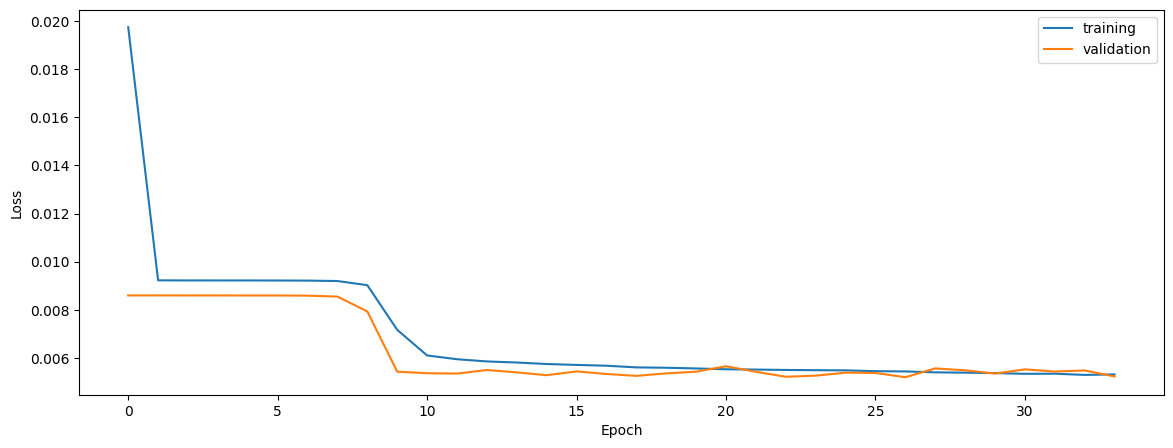

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.6433337496285763
0.6301447357389467
0.6668783050151096


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.6433337496285763
0.6301447357389467
0.6668783050151096


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.6363862356375024
0.6261254128505092
0.6577190738968446


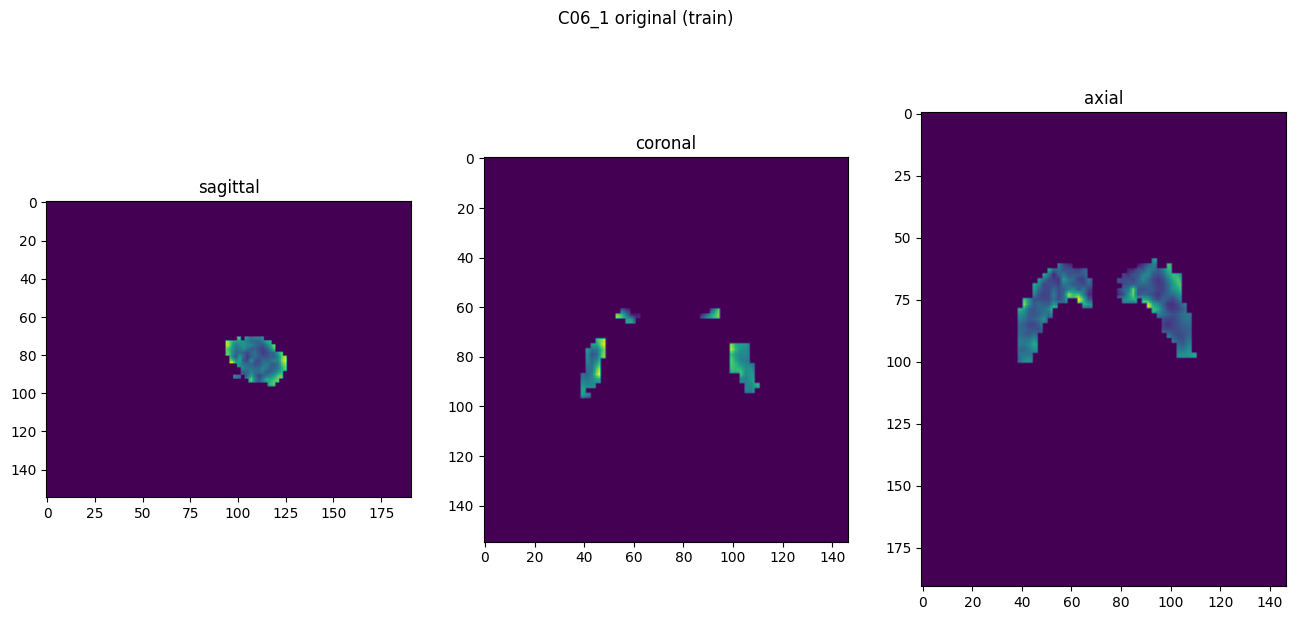

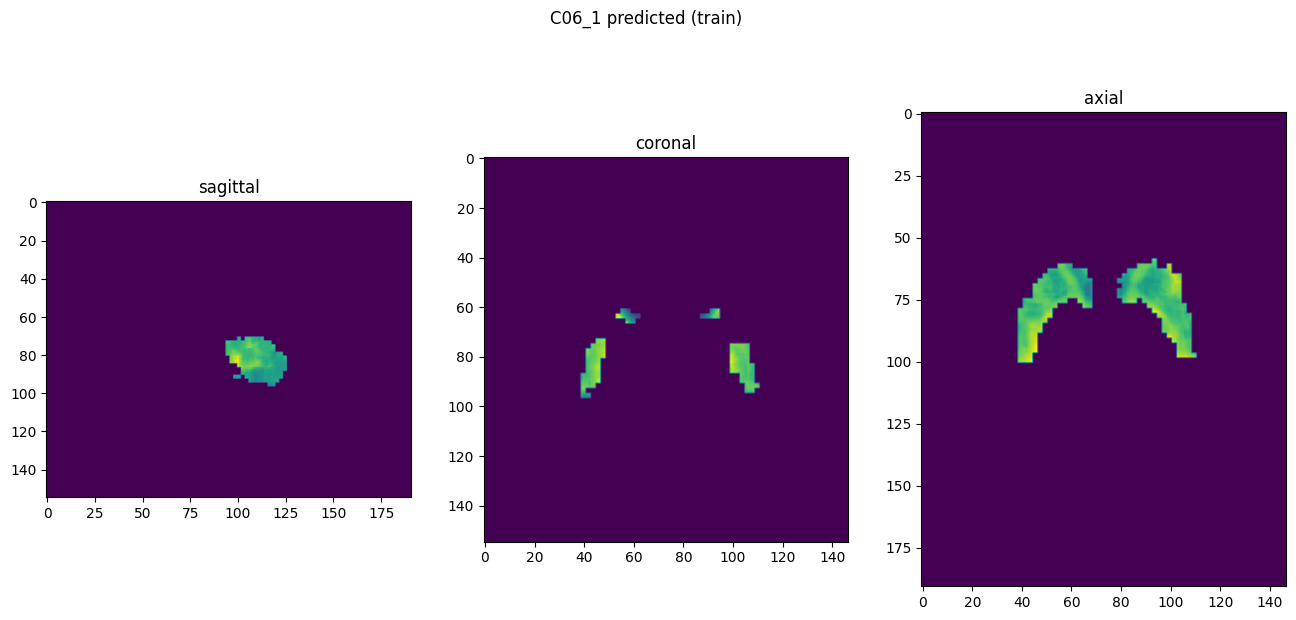

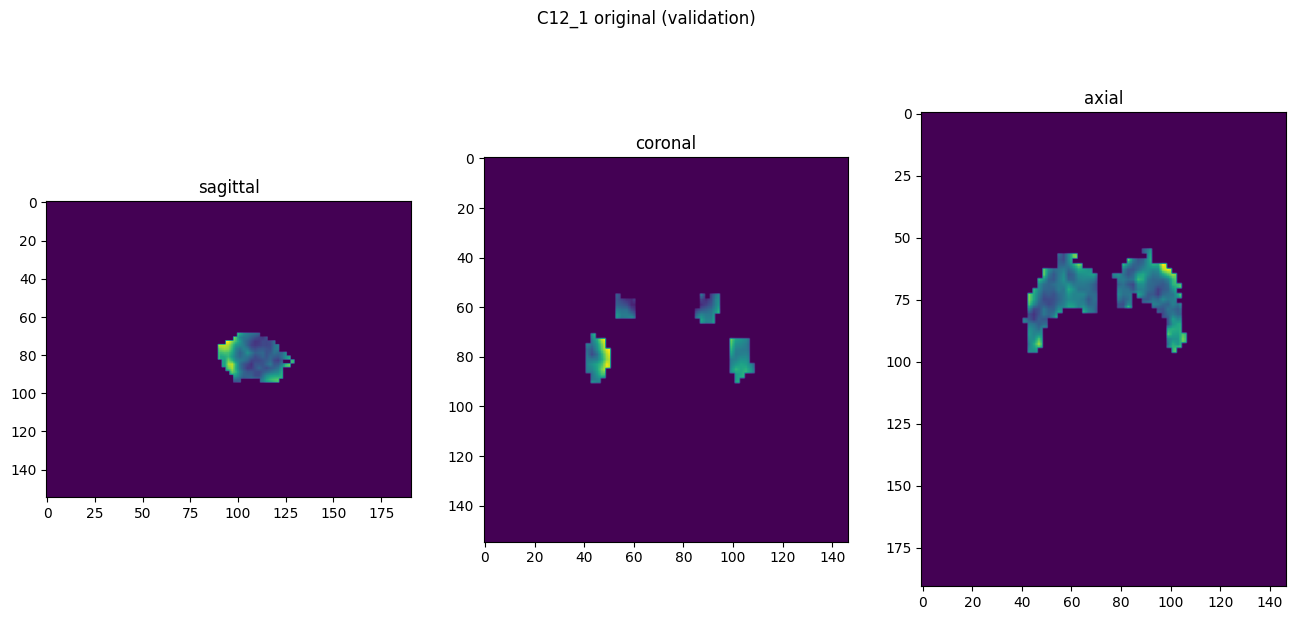

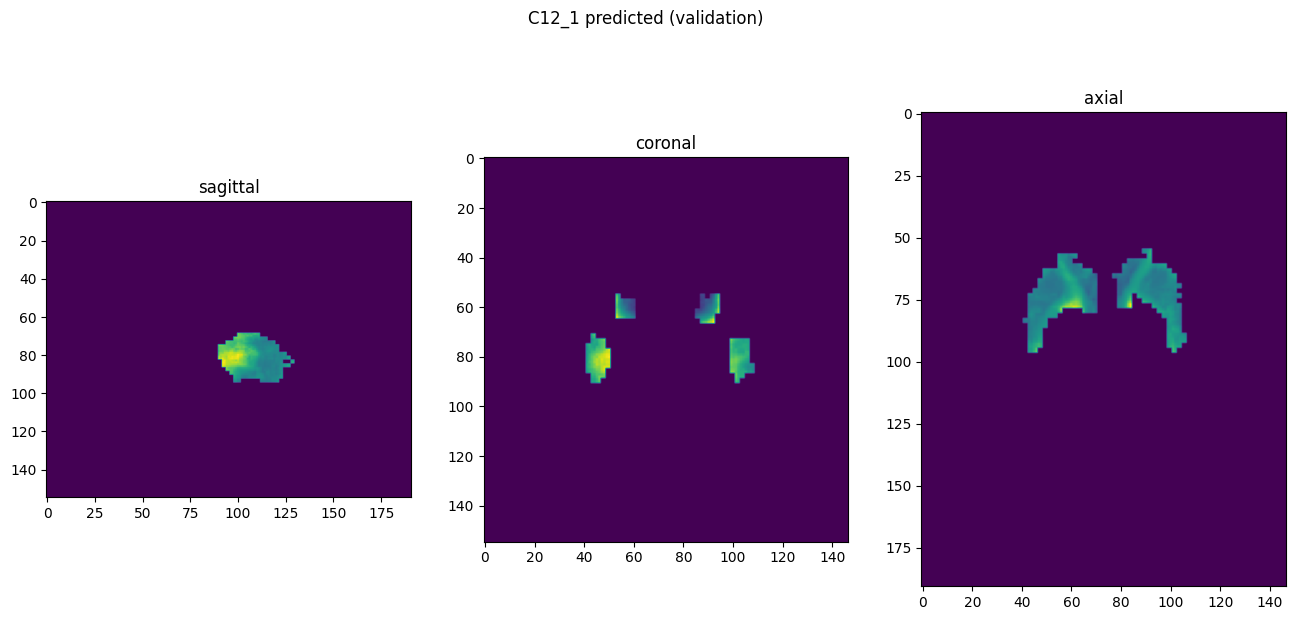

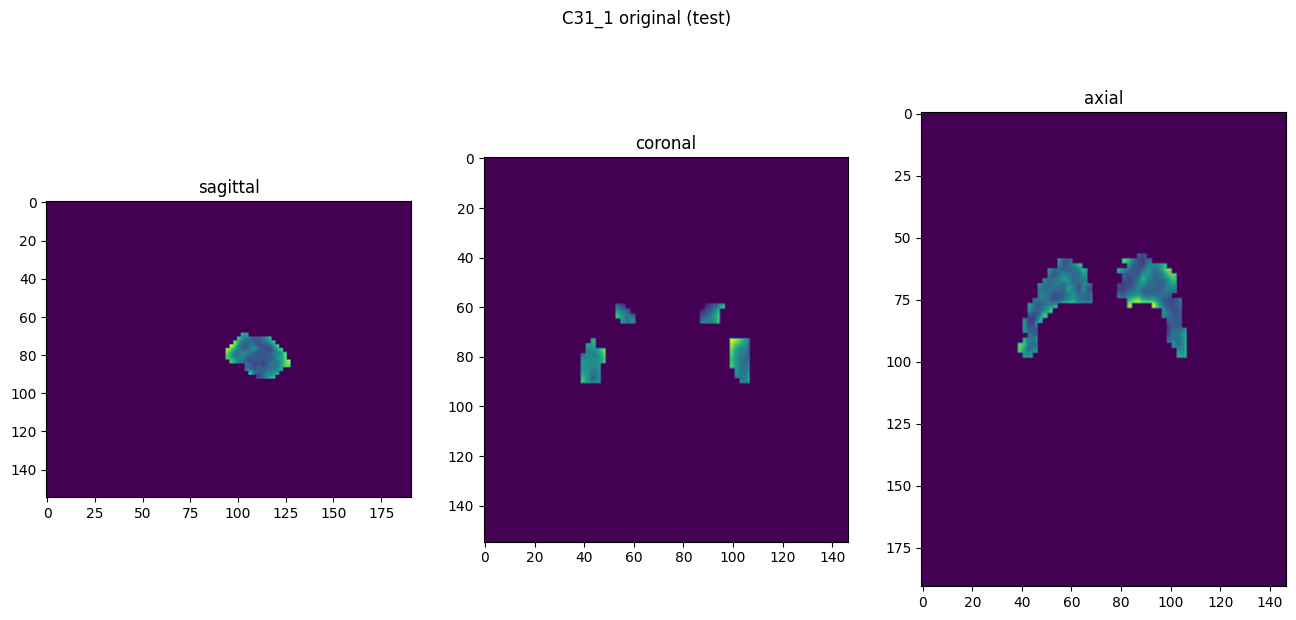

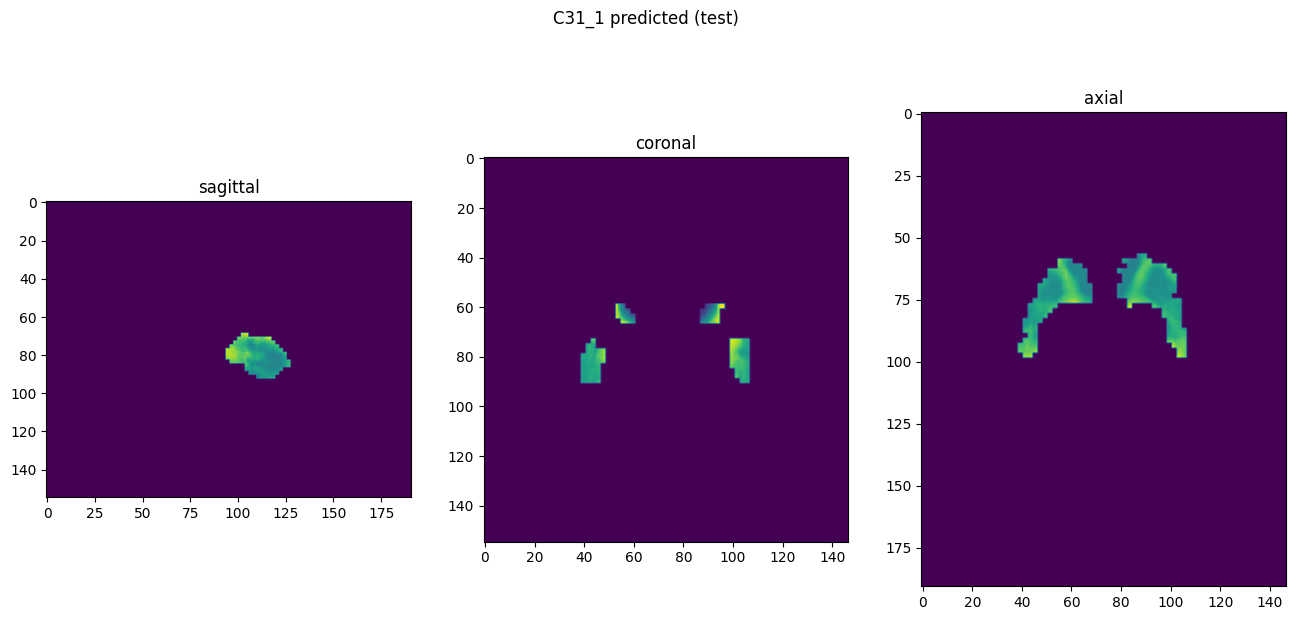

In [10]:
showResults(model, gen, threshold=None, background=False)